# Trabalho III - Método de Wang-Landau
### Gabriel Victor Carvalho Rocha - 2018054907

In [2]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
import math

In [3]:
N_ITER = 10000000
FLATNESS = 0.8

In [4]:
@jit(nopython=True)
def estado_inicial(N):
    s = np.zeros(N, dtype=np.int8)
    for i in range(N):
        s[i] = np.sign(2 * np.random.random() - 1)
    return s

In [5]:
@jit(nopython=True)
def vizinhos(L, N):
    viz = np.zeros((N, 4), dtype = np.int16)
    for k in range(N):
        viz[k, 0] = k + 1
        if (k + 1) % L == 0: viz[k, 0] = k + 1 - L
        viz[k, 1] = k + L
        if k > (N - L - 1): viz[k, 1] = k + L - N
        viz[k, 2] = k - 1
        if k % L == 0: viz[k, 2] = k + L - 1
        viz[k, 3] = k - L
        if k < L: viz[k, 3] = k + N - L
    return viz

In [6]:
@jit(nopython=True)
def energia(s, viz, N):
    ener = 0
    for i in range(N):
        h = s[viz[i, 0]] + s[viz[i, 1]]
        ener -= s[i] * h
    ener = int((ener + 2 * N) / 4)
    return ener

In [7]:
@jit(nopython=True)
def min_h(H, N):
    min_h = H[0]
    for i in range(2, N - 1):
        if H[i] < min_h: min_h = H[i]
    if H[-1] < min_h: min_h = H[-1]
    return min_h

In [8]:
@jit(nopython=True)
def wang_landau(L, N_ITER, FLATNESS):
    N = L * L
    s = estado_inicial(N)
    viz = vizinhos(L, N)
    ener = energia(s, viz, N)
    ln_ge = np.zeros(N + 1, dtype=np.float64)
    H = np.zeros(N + 1, dtype=np.int64)
    Hc = np.zeros(N + 1, dtype=np.int64)
    m_micro = np.zeros(N + 1, dtype=np.float64)
    ln_f = 1.0
    m = s.sum()
    for it in range(N_ITER):
        for imc in range(N):
            k = np.random.randint(0, N - 1)
            h = s[viz[k, 0]] + s[viz[k, 1]] + s[viz[k, 2]] + s[viz[k, 3]]
            ener_2 = ener + int(s[k] * h * 0.5)
            if ln_ge[ener] > ln_ge[ener_2]:
                s[k] = -s[k]
                ener = ener_2
                m -= 2 * s[k]
            else:
                p = np.exp(ln_ge[ener] - ln_ge[ener_2])
                if np.random.random() < p:
                    s[k] = -s[k]
                    ener = ener_2
                    m -= 2 * s[k]
            H[ener] += 1
            ln_ge[ener] += ln_f
            m_micro[ener] += abs(m)
        if it % 1000 == 0:
            h_med = float(H.sum()) / float((N - 1))
            h_min = min_h(H, N)
            if h_min > (FLATNESS * h_med):
                Hc += H
                H = np.zeros(N + 1, dtype = np.int64)
                ln_f = 0.5 * ln_f
        if ln_f < 0.00000001: break
    m_micro = m_micro / Hc
    ln_ge = ln_ge - ln_ge[0] + np.log(2)
    return ln_ge, m_micro, ener, s

In [9]:
@jit(nopython=True)
def energia_reescalada(e, N):
    return e * 4 - 2 * N 

In [10]:
@jit(nopython=True)
def maior_exp(b, N):
    maior = 0
    for e_esc in range(N):
        e = energia_reescalada(e_esc, N)
        if -b * e > maior:
            maior = -b * e
    return maior

In [15]:
@jit(nopython=True)
def media_termodinamica(ln_ge, t, L):
    N = L * L
    ge = np.exp(ln_ge)
    z = e_t = e_t2 = 0
    b = 1 / t
    e_min = 0
    maior = maior_exp(b, N)
    for e_esc in range(N - 1):
        if e_esc == 1: continue
        e = energia_reescalada(e_esc, N)
        e_ = e - e_min
        expoente = np.exp(-b * e_ - maior)
        z += ge[e_esc] * expoente
        e_t += e_ * ge[e_esc] * expoente
        e_t2 += (e_ ** 2) * ge[e_esc] * expoente
    e_t /= z
    e_t2 /= z
    z *= np.exp(-b * e_min)
    cv = ((b ** 2) * (e_t2 - (e_t ** 2))) / N
    e = (e_t + e_min) / N
    return z, e, cv

In [12]:
ln_ge, m_micro = {}, {}
temperaturas = np.arange(start = 1, stop = 5.1, step = 0.1, dtype = np.float64)

for L in [6, 12, 18]:
    ln_ge_t, m_micro_t, ener_t, s_t = wang_landau(L, N_ITER, FLATNESS)
    ln_ge[L] = ln_ge_t
    m_micro[L] = m_micro_t

ln_ge[24] = np.array([0.69314718055994529, 7.0356163661506894, 7.7300972025421384, 12.708447990897012, 14.091362101915193, 18.014393253209899, 19.779702497604202, 23.097433386328529, 25.092024354222129, 27.996628550770591, 30.139682901981185, 32.785065365913226, 34.993354735853984, 37.465122757437541, 39.710720790508105, 42.069110108497455, 44.291723800781085, 46.578418014529063, 48.788970021488979, 51.016086323144748, 53.194800196173503, 55.361592946532085, 57.519252194049670, 59.650978622916057, 61.779952613594844, 63.886640680911853, 65.987850530031039, 68.071593983056857, 70.141452668192699, 72.191713495138004, 74.249246401670291, 76.279393522026851, 78.302181897642924, 80.306387258651569, 82.312618134501292, 84.298879859927013, 86.292898042085483, 88.257061673286273, 90.235155863645389, 92.182553319218471, 94.144019929650142, 96.077129660132243, 98.026074124458148, 99.947100592735126, 101.86657486665518, 103.76936796117099, 105.67975294399531, 107.57512399363787, 109.46828470933707, 111.34779341328414, 113.23076058733733, 115.09648379493029, 116.96815481591494, 118.83135989117892, 120.68892082381518, 122.54173716712268, 124.39026768315108, 126.22483272660048, 128.06534236479075, 129.89411973762782, 131.72354762065680, 133.54110620725424, 135.36197508681090, 137.17323036301406, 138.98524442124636, 140.78858306813510, 142.58834156203540, 144.38168187248976, 146.17299730885298, 147.96011288273604, 149.74348038244517, 151.51939642238887, 153.29622126925261, 155.07975046146186, 156.85007737386496, 158.62461346197398, 160.38527886379035, 162.15522989440234, 163.90769970226557, 165.66133388686450, 167.41388514447482, 169.16233767378600, 170.90808003950389, 172.65395274567874, 174.39845940280230, 176.14175073612006, 177.88164315927298, 179.61414100039275, 181.35247473228247, 183.08508813190730, 184.81777159679206, 186.53822178948195, 188.26958532440932, 189.99191701221736, 191.71690869140895, 193.44236318576606, 195.16167989182742, 196.87709903526576, 198.59434453952582, 200.30228631007941, 202.01110651898654, 203.71056343424590, 205.41761778104575, 207.11625242042811, 208.81519774902137, 210.51231592703135, 212.20249266732009, 213.89642967093260, 215.58371054935725, 217.26344591188700, 218.94724780130656, 220.62314531016619, 222.30249246764453, 223.97278609681399, 225.63619220066340, 227.30230423617633, 228.95861157584460, 230.62048679399760, 232.26534525859626, 233.91498359847338, 235.56029633987220, 237.19840803551944, 238.83628313052924, 240.46414294648440, 242.08877405333789, 243.71293140757354, 245.32942043054373, 246.94615548658641, 248.54083947646888, 250.14503082442553, 251.73544749427111, 253.32749779331954, 254.91292683589728, 256.49370011496814, 258.06964959013732, 259.63836878347666, 261.20152289974959, 262.75986088621886, 264.30741631794245, 265.86024096417697, 267.39566285717757, 268.92968916702540, 270.46201522457869, 271.98789572525294, 273.50085761952670, 275.01144860494406, 276.51359003591807, 278.00967411506446, 279.49977291929991, 280.97768287170203, 282.45486122179301, 283.92675694632800, 285.39676205623419, 286.85068625021250, 288.29968386698039, 289.74692024100096, 291.17946429360182, 292.61224233913691, 294.03584882426532, 295.45632687020571, 296.86630360591681, 298.26986884880336, 299.66270157504351, 301.05177078950675, 302.43157033431800, 303.80275554764540, 305.17196138012679, 306.53336053896220, 307.88285156894000, 309.22158232140811, 310.55538469362529, 311.88714232850344, 313.20480212378772, 314.52261070716651, 315.82390761184962, 317.11805937993796, 318.40495261359484, 319.68681224990161, 320.95468005347522, 322.21886895406516, 323.47495105672152, 324.71972214985163, 325.95918954718383, 327.19090775954993, 328.41154980469020, 329.62828555512698, 330.83055826831134, 332.02776595759661, 333.21240974772246, 334.38779882896216, 335.55344162690909, 336.71662927973540, 337.87064002263816, 339.00824522781642, 340.14160953271659, 341.26939379978450, 342.38758517611296, 343.49403612125190, 344.58569347667964, 345.66798384297164, 346.73726755190165, 347.80611583400042, 348.85483972537787, 349.90041351127894, 350.93299057889254, 351.95955911088259, 352.97602793383868, 353.98255526829035, 354.97834147322448, 355.96554256785186, 356.94125596988471, 357.90497088241847, 358.85755826342375, 359.80189847755702, 360.73642419088156, 361.65660518217356, 362.56636084425719, 363.46633083927901, 364.35692901718886, 365.23133884179862, 366.10365865934165, 366.95995068359645, 367.80509353983672, 368.63809950459273, 369.45915674972804, 370.26935267257960, 371.07229879308017, 371.86319692242415, 372.64355678665908, 373.40965562868388, 374.16625825870307, 374.90839841771395, 375.63724458027156, 376.35899734306605, 377.06544858026774, 377.76025104332240, 378.44094423759253, 379.10956750619681, 379.77108755517276, 380.42071509170802, 381.05380989420684, 381.67560049701007, 382.28633117485316, 382.88372936654361, 383.46794237005980, 384.03808373022349, 384.59817929375441, 385.14751264262469, 385.68266415405543, 386.20462193894656, 386.71535207140715, 387.21015783953936, 387.69472025144370, 388.16721629905970, 388.62289801049502, 389.06799714076789, 389.49822398829730, 389.91649754154952, 390.32258440363677, 390.71513332236083, 391.09174181330474, 391.45892283129962, 391.80752725708754, 392.14620584059031, 392.47177186417849, 392.78558109510215, 393.08409364331038, 393.36716358173163, 393.63688738453658, 393.89363582241805, 394.13847145247729, 394.36929225731166, 394.58356113541396, 394.78413130152495, 394.97053724336894, 395.14482258069785, 395.30716915238173, 395.45700369584830, 395.58884179401667, 395.70693962085517, 395.81012773323329, 395.90076036560805, 395.97807217943938, 396.04273263919623, 396.09277581978114, 396.13063876140387, 396.15106120515139, 396.15868358123572, 396.15240250337393, 396.13338538813861, 396.09684085655482, 396.04864585209162, 395.98320294726165, 395.90852151620658, 395.81786349225314, 395.71272505629332, 395.59250737536223, 395.46058615851672, 395.31497463393481, 395.15702029872210, 394.98603790807994, 394.79937359500201, 394.59795625317366, 394.38363513160022, 394.15210027802260, 393.91058422434600, 393.65178769636424, 393.38208888280661, 393.09581430065901, 392.79582582223685, 392.48129652250083, 392.15714549827845, 391.81660981285842, 391.46146672773631, 391.09843426752360, 390.72083625006945, 390.32938410151274, 389.92393307197364, 389.50818700897963, 389.07442340064318, 388.63172665047915, 388.17641575444014, 387.70660738456519, 387.22447207379611, 386.72869278300078, 386.22155646789344, 385.70052717435630, 385.16575768399508, 384.62023421931536, 384.05683907676013, 383.48190109241278, 382.89589291620524, 382.29735921132834, 381.68951430726321, 381.06776016760142, 380.43298835861953, 379.77941292333873, 379.12306213188441, 378.45067933011325, 377.76817644942076, 377.07186031151087, 376.36376479077609, 375.64437593329222, 374.91504238355429, 374.17130729365618, 373.41596638965876, 372.64765612590583, 371.86705839443476, 371.07642642963202, 370.27538451361926, 369.45983536350997, 368.63841622877391, 367.80022784877093, 366.95487260628016, 366.10042109895022, 365.23674869346888, 364.35578995752604, 363.46635153699191, 362.56377540338309, 361.64985665488513, 360.72873198795588, 359.79354126560958, 358.84719607043536, 357.88777169394763, 356.92273048866065, 355.94903145540030, 354.96455910611422, 353.97374526965888, 352.96589442897113, 351.94844130981238, 350.92034905958445, 349.88447625744612, 348.84125713813575, 347.78565163719924, 346.71493546474250, 345.63611028898032, 344.55286778319152, 343.45701327729495, 342.35359392869742, 341.23804110098155, 340.11703394162924, 338.98529584515364, 337.83857677686484, 336.68729226100714, 335.52745346534522, 334.35464571225913, 333.17379399943621, 331.98816162157328, 330.79585860479148, 329.58982403385909, 328.37579956460269, 327.14960530209811, 325.91361935246260, 324.67230097759040, 323.42461415934832, 322.17244665134223, 320.90540739703448, 319.62810317981513, 318.34597968864711, 317.05997185218604, 315.76818452585013, 314.45911817062171, 313.14830612945826, 311.83002036619456, 310.50463630068572, 309.16845845985682, 307.82232413995536, 306.47332845437796, 305.11413387763770, 303.74481397676738, 302.36998788821967, 300.99216405856879, 299.60518991756709, 298.20990982461245, 296.80737660634787, 295.39726310777934, 293.97876506853373, 292.55129501033099, 291.12349183666976, 289.68825256634028, 288.24785758364470, 286.79448130536349, 285.33419436025889, 283.86994910049708, 282.40273736226828, 280.92794629740985, 279.44194464195044, 277.95463360655577, 276.45422078478606, 274.94349479484828, 273.43232227671416, 271.91006289232047, 270.39040280688079, 268.86036737072737, 267.33333354997905, 265.79415525305541, 264.25097898948462, 262.70163033712180, 261.14470547247203, 259.57897376823695, 258.00556491124900, 256.43268845784934, 254.85301786470683, 253.26975366282733, 251.67934703636439, 250.08286171961100, 248.48074358511241, 246.87954394328864, 245.26743346262248, 243.64893422830374, 242.03134007561476, 240.40784615087779, 238.77772170114787, 237.14720758605273, 235.50986525225909, 233.86346348929675, 232.21686515021594, 230.56581920194895, 228.91108330893786, 227.25386741566928, 225.59170895624430, 223.92750938046248, 222.25640722918780, 220.58193355608256, 218.90591957974704, 217.21981364298136, 215.53390016961367, 213.84488597321780, 212.15283003258975, 210.46270583379538, 208.76724263835223, 207.06303512859614, 205.36366058695586, 203.65884487140448, 201.95330726909907, 200.24711938011916, 198.53840961861880, 196.82628428745539, 195.10919450032981, 193.38679668116839, 191.67030988443167, 189.94889117586882, 188.22298006522925, 186.49362923014434, 184.77044288623603, 183.03621785152228, 181.30098539400370, 179.56489908504756, 177.83453726578028, 176.08926790762217, 174.34295262205870, 172.60789482105048, 170.86076247501643, 169.11227129209311, 167.36191279995711, 165.60962800491126, 163.84970938968928, 162.09298591125281, 160.33417005646498, 158.56918392885001, 156.80021214294703, 155.03152544606002, 153.25434489357741, 151.48648208189280, 149.71058676946433, 147.92033554423125, 146.13429908263953, 144.34506146419318, 142.55626006233962, 140.76071260679038, 138.96099933791430, 137.14772097575934, 135.33436141717704, 133.51452719974787, 131.69320398378642, 129.86718238699706, 128.04925785768302, 126.21637494671614, 124.37455114531787, 122.52786113131316, 120.68070578384669, 118.82097674715789, 116.95627394128115, 115.08651447105677, 113.21579833138259, 111.32961530792983, 109.44749986934931, 107.55643088925154, 105.66252687382968, 103.75495216059954, 101.84676338541777, 99.929718462708308, 98.003726182463481, 96.074546990874126, 94.135458184364154, 92.185299364807918, 90.239011539104297, 88.266197128179385, 86.290283797266795, 84.298719210508182, 82.302103696348979, 80.315283967140033, 78.296085311057880, 76.275954572441890, 74.236639914992168, 72.188902033450915, 70.141621975186183, 68.068200318100764, 65.990517539861514, 63.890739677431895, 61.789361638906314, 59.649967996361568, 57.524771569254710, 55.367480529430225, 53.184938473584964, 51.014157159211948, 48.783744884612872, 46.593529207589938, 44.301687164190128, 42.072645319583728, 39.712861506226375, 37.487363709094836, 35.003397641661479, 32.803546873810603, 30.158405093434165, 28.023271797182868, 25.107088057282279, 23.109209416392158, 19.803320450666259, 18.038177860858749, 14.121778471353364, 12.741751639130426, 7.7668272535827878, 7.0575419943359616, 0.75782544720442313])
m_micro[24] = np.array([568.16672687098605, 564.34123407338723, 562.51675534113497, 562.12983421828142, 559.83070640710810, 559.67353305849565, 556.97095311515307, 557.49365622960431, 555.39718636983514, 554.81007446749300, 553.48573305631066, 552.46496990705646, 551.72847810087364, 551.35022444161564, 549.27421619045629, 548.15305048682319, 546.49994651905479, 545.63115808924624, 544.05972327050699, 542.80302435473175, 541.66657115239366, 539.95253434641097, 539.03640788357166, 537.14699211649884, 535.68506842842248, 533.80979628439434, 532.55445496138009, 530.49175997516056, 529.44243821588555, 527.97234332138135, 526.32839135007498, 523.77884431500581, 522.67321319320274, 520.69045711429885, 518.89595549797343, 516.38734576952152, 515.07312246892434, 512.97669329298299, 510.95336135417313, 508.76630291435470, 507.10940462174625, 504.62205095690632, 503.01082379930585, 501.06537198980720, 499.15592181419947, 497.26374029489631, 494.62563144998114, 492.60465637040210, 489.88848283342315, 487.52170194999968, 485.09738288039728, 482.60363746024279, 480.22105413838750, 477.88194785804825, 474.93084839865287, 472.29804071884536, 469.66692112009349, 467.52516385891022, 464.74954691336586, 462.10537521476692, 459.36679303156245, 456.53842539878883, 453.75197659716918, 450.49883207151157, 447.68315556575249, 444.58466626967476, 441.28199204761125, 438.65660334210935, 435.51071016877819, 432.90155014063703, 429.17100731574516, 425.83939058117090, 422.94984938931884, 419.59049018597437, 415.73440040730623, 412.26762880237669, 408.28539609932409, 404.48111755841063, 400.53184264462811, 396.42411507583080, 392.43354709023174, 387.61408492394185, 383.53663709701181, 378.99996151891480, 374.15211892005186, 369.35037276169572, 364.65194402509894, 359.64893414677135, 353.90807512586616, 348.43057312306178, 342.42687198029489, 336.89499773421142, 330.24039834060068, 324.15599449992459, 318.08155212296998, 311.66380847052216, 305.31895684283404, 298.80995684957918, 292.67890047610263, 286.49261838467623, 280.23248426447492, 273.80163013795556, 267.52896434860963, 261.58289168617790, 255.52042689150818, 248.92916296615806, 243.27862167277786, 237.86573595452353, 232.18448942327288, 226.51552584253415, 221.01050125672381, 215.49574194387750, 210.50699752531693, 205.32709114582318, 200.16408293589245, 195.21492453621536, 190.61151448549506, 186.18896068181368, 181.83379452007733, 178.09359690354350, 174.26018579393775, 170.77589470087210, 167.42535480892846, 164.07318646891923, 160.78658072010430, 157.58660492417255, 155.10238888018964, 152.07492284450802, 149.06892959574409, 146.93673850644069, 144.21826434735112, 142.21417051428722, 140.51124743163436, 138.54564673954678, 135.89676697334053, 133.43914858307960, 131.39953198677242, 129.88149940737495, 127.87525289461252, 126.07948940070679, 124.06153095391575, 122.74836139055046, 121.61927165937918, 120.10790179074294, 118.33529144603543, 116.91944634670149, 115.51002939359581, 113.87771349920931, 112.86118748277264, 111.65122037330633, 110.65401697294210, 109.55413220487691, 108.56733432511443, 107.66336833021717, 106.44012561493975, 105.49132146423008, 104.35396111222424, 103.35744862584538, 102.47098603802830, 101.59772232839862, 101.00858361755853, 100.31414614273571, 99.405311855558310, 98.686864137971483, 98.090821591418432, 97.611803146221547, 96.725327887269160, 96.097333069992459, 95.489057282059832, 95.028808705536150, 94.547097384043980, 94.124887728494471, 93.636698844817303, 92.988739156735889, 92.702971759728754, 92.398219225363036, 91.878981642946002, 91.500191586900357, 91.435044673087930, 91.026127062043869, 90.725374065463882, 90.576800438770618, 90.361934298876875, 90.060312747148402, 89.668561286439711, 89.374297068758295, 89.143523054709405, 88.858752432927275, 88.513469659628328, 88.304057286049499, 88.156135495909098, 87.795291322782745, 87.480030594768962, 87.363374176700603, 87.241793564941631, 87.185503275783077, 86.977219111909378, 86.878007002728836, 86.479749832494917, 86.341198527972182, 86.257078413478979, 86.046247945506835, 86.002597564832541, 85.970080102931419, 85.810448982503132, 85.632315864228332, 85.492317541402159, 85.344224660295865, 85.265610716193450, 85.268712625247602, 85.319626431755211, 85.164991892863554, 85.106784435263066, 85.061505191932667, 85.094212272721137, 84.975007271168977, 84.892973818616852, 84.809155012802833, 84.847115217184182, 84.692253420925468, 84.644808934110017, 84.544156301450016, 84.547048755805733, 84.529954359232605, 84.398040931368087, 84.408091670356868, 84.480397589067820, 84.450753421660195, 84.433516215892709, 84.398677757086702, 84.342744806016825, 84.296813099060032, 84.139237495877737, 84.107757107873439, 84.023242244481182, 83.977513373562559, 83.961573613634741, 83.927497819906279, 83.914307372013070, 83.948021207602039, 83.947757899585937, 83.936790077366680, 83.933864380843872, 83.913066991144461, 83.937056037294610, 83.918115887074563, 83.920709428600432, 83.938651563419000, 83.946014498551747, 83.883796166719193, 83.913177523586938, 83.972637192296176, 83.987996078714588, 83.970277116037835, 83.998317751568578, 83.960440485141021, 83.945471249785044, 83.998799089554751, 84.002976690511872, 83.980247964041240, 83.984155197568242, 84.016508187752308, 83.985675719538165, 83.916726137035070, 83.959724664911931, 83.893541939425972, 83.882615061344808, 83.933025206359432, 83.962126360053404, 83.972194271651517, 83.988672514861904, 83.971530061183202, 84.000692478298049, 83.959215903655277, 83.983690919220209, 84.005142450793514, 84.030610673107901, 84.018411311815214, 84.026575223878893, 84.001433232773877, 83.976289795274965, 83.977788182804659, 83.976064961435711, 84.011760621520068, 84.020088422010829, 84.026496144427099, 84.092228975232473, 84.123236654010739, 84.150262276244419, 84.122592154460662, 84.147270319194504, 84.117047512469341, 84.146806488839204, 84.126298029428412, 84.159800294749800, 84.118641918780398, 84.123106590161896, 84.140027511253052, 84.133841557358210, 84.130288036779703, 84.114099208065369, 84.107736046072489, 84.145152813912986, 84.102629486095154, 84.127475062055368, 84.093171354593494, 84.101007210576924, 84.099945889709559, 84.095783222973353, 84.095723225220723, 84.093730560042729, 84.119104264146486, 84.086352471651182, 84.073142900829197, 84.062988465282643, 84.035580500496991, 84.034661136860365, 84.025218425325605, 84.056009948500147, 84.102383116898295, 84.034709590586232, 84.002480056076635, 83.981594412315332, 84.005008733167202, 84.039729296856422, 84.053885544255309, 84.031351086691885, 84.080272951772130, 84.042776128772459, 84.062388307657130, 84.058377818484459, 84.031676555447405, 84.021597662871955, 84.010899011046661, 83.973665816377775, 83.981352023477129, 83.955525376675254, 83.973238659357634, 83.975646326533209, 84.017924332849915, 84.033350402269846, 83.996453335605125, 83.998478170866889, 84.026764377460538, 84.039109781702251, 83.989876053239698, 83.989271402714721, 83.991559997662051, 84.019348252856972, 84.016034799494889, 83.998750429894145, 84.009675810273990, 84.016835527260525, 84.029382609646959, 83.986914436565044, 83.995524046481009, 84.001310888484042, 83.979431042068711, 83.986577552714252, 83.946797085691742, 83.972944350655780, 83.950256553931823, 83.965215811248100, 83.940811324538103, 83.925635275542163, 83.957600890714744, 83.939052554759542, 83.955977553170669, 84.001720005573716, 83.989169172968701, 84.037333872845949, 84.023461553087031, 84.037833859601321, 84.040052215352333, 84.045484437817834, 84.044417597678631, 84.055763172124003, 84.042152820422842, 84.027141993780745, 84.025021373212709, 84.062194119994160, 84.058039419812147, 84.014320074103978, 84.016993102752622, 83.985498928287015, 84.009685834896032, 84.000382890039475, 84.013963619645011, 83.981621867231823, 83.979289700568756, 84.010993876727312, 84.031450067590313, 84.029323651957156, 84.016955016731487, 83.992531718039686, 83.972129107694286, 83.920078296629612, 83.939880281389847, 83.953137353320571, 83.957789250714313, 83.990355227448418, 84.029177280613709, 84.042620920116377, 84.084474313837632, 84.108873817513626, 84.091103266753876, 84.049640558583832, 84.068886626717187, 84.080452260960271, 84.061315918549468, 84.090809278589077, 84.076954995871859, 84.060631614619922, 84.092407143733439, 84.084405377510507, 84.054712239917379, 84.069255256789475, 84.083407493423891, 84.040187786890257, 84.032383397089987, 84.076543884408665, 84.039116794434491, 84.021645490261236, 84.051061168376776, 84.028024518991444, 84.026419337448729, 84.057175142060927, 84.038327704565873, 84.025937428433508, 83.998713254823898, 83.978830402213816, 83.949162149923751, 83.930533838742789, 84.029612484929530, 84.051816535462166, 84.111767133823022, 84.075227661184115, 84.039759700362055, 84.052593245118516, 84.025928093222319, 84.059080522285313, 84.007588866758269, 84.032752465408720, 84.009567088581690, 84.036778511419726, 84.010559463197851, 83.981912046390804, 83.959937021938885, 83.974613651050873, 83.990532557602975, 83.986233156622760, 83.951462776661941, 83.964365280959498, 84.006959299788392, 84.037693926783533, 84.043427856454045, 84.021588916682347, 84.017721738646429, 84.037996656304699, 84.045781607307219, 84.035940782009590, 84.039538220812673, 84.054706517477925, 84.063908633714618, 84.055060435881273, 84.074679308747704, 84.072275466578446, 84.053305987922883, 84.066770246826366, 84.038849610849525, 84.035688811785633, 83.976850160923007, 83.997876817686119, 83.981615407927464, 83.941648186256344, 83.971765814137228, 83.958938993543683, 83.958140053111961, 84.003649326078872, 84.023079061826124, 84.020440383581047, 83.987322261019443, 84.026796869494433, 84.019306858619402, 83.993436797088364, 84.020023133850657, 84.003560492489598, 84.023920739583801, 84.036297191526643, 84.002454985078742, 83.994383468645367, 83.927955462144681, 83.911893780258438, 83.910245368784729, 83.994171749147085, 83.986990648147128, 83.973720281861816, 84.005465361430083, 83.987838909475357, 83.989193863871421, 83.976356263744478, 83.986601109962805, 84.014084396723788, 84.015828719246159, 83.970679912141946, 83.971461889954753, 83.966054844611932, 83.952093117871996, 83.951235474320143, 83.965198722541984, 83.959546252648934, 83.975069951351742, 84.020781726816395, 83.967437887185724, 84.063979923569562, 84.072116666501230, 84.090065445229001, 84.033932434464234, 84.023896094983186, 84.036347332832051, 84.002499966710360, 84.085040329869926, 84.044360725477176, 84.080716750470344, 84.043437652671201, 84.029701252705891, 84.016358952033144, 83.963351225165951, 84.000338943279147, 84.002873121910326, 83.988593219729225, 83.999487028313979, 83.982371112986257, 84.009986062146425, 84.057642762600111, 84.061473243741261, 84.083318933963398, 84.079243170055364, 84.062802324176729, 84.021292879706536, 84.048745837867159, 84.027033470746503, 84.022040998512935, 83.989189471395576, 83.979564483990487, 84.032999180233475, 84.052798028663545, 84.046269304677764, 84.017346311287014, 84.026007134169120, 84.005822755407152, 84.016764454797396, 84.010212103063111, 84.020777625591251, 84.027937070085699, 83.983586822367798, 84.031945786652628, 84.038313981204851, 83.994763879103147, 84.011693900727309, 84.019955277485664, 84.008550911071424, 83.997442623760946, 83.959556781964707, 83.971076997934119, 84.001235590935465, 83.965798575732748, 83.985534247997393, 84.019609219352844, 84.010824066347638, 83.993426155622402, 84.015691523012734, 84.000000000000000, 84.025870714137412, 84.000000000000000])

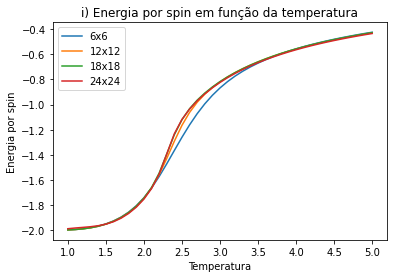

In [16]:
#i) Energia por spin, e, como função da temperatura

def grafico_temperatura_energiaporspin(L):
    e = np.array([])

    for t in temperaturas:
        z_t, e_t, cv_t = media_termodinamica(ln_ge[L], t, L)
        e = np.append(e, e_t)

    plt.plot(temperaturas, e, label=f"{L}x{L}")
    
for L in [6, 12, 18, 24]:
    grafico_temperatura_energiaporspin(L)

plt.xlabel("Temperatura")
plt.ylabel("Energia por spin")
plt.legend()
plt.title("i) Energia por spin em função da temperatura")
plt.show()

Através do gráfico i, podemos notar que a medida que a temperatura aumenta, o valor da energia por spin também aumenta, mas a energia por spin tem sua taxa de crescimento diminuida depois da temperatura 3.

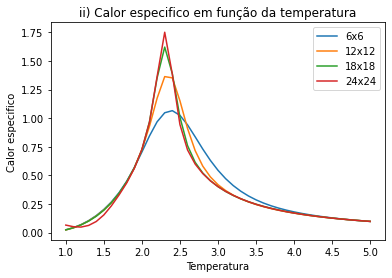

In [17]:
#ii) Calor específico, cv, como função da temperatura

def grafico_temperatura_caloresp(L):
    cv = np.array([])

    for t in temperaturas:
        z_t, e_t, cv_t = media_termodinamica(ln_ge[L], t, L)
        cv = np.append(cv, cv_t)

    plt.plot(temperaturas, cv, label=f"{L}x{L}")
    
for L in [6, 12, 18, 24]:
    grafico_temperatura_caloresp(L)


plt.xlabel("Temperatura")
plt.ylabel("Calor especifico")
plt.legend()
plt.title("ii) Calor especifico em função da temperatura")
plt.show()

Pelo gráfico ii, podemos notar um pico de crescimento do calor especifico entre as temperaturas 2 e 2.5, tendo uma grande queda logo em seguida. 

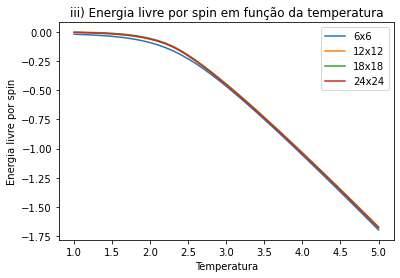

In [18]:
#iii) Energia livre por spin
def grafico_temperatura_energialivreporspin(L):
    N = L * L
    f_t = np.array([])
    
    for t in temperaturas:
        z_t, e_t, cv_t = media_termodinamica(ln_ge[L], t, L)
        f_t = np.append(f_t, -(1 / (N * (1 / t))) * math.log(z_t))

    plt.plot(temperaturas, f_t, label=f"{L}x{L}")
    
for L in [6, 12, 18, 24]:
    grafico_temperatura_energialivreporspin(L)


plt.xlabel("Temperatura")
plt.ylabel("Energia livre por spin")
plt.legend()
plt.title("iii) Energia livre por spin em função da temperatura")
plt.show()

Podemos notar que no gráfico iii a energia livre por spin diminui conforme a temperatura aumenta.

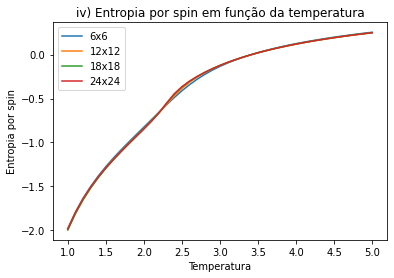

In [19]:
#iv) Entropia por spin
def grafico_temperatura_entropiaporspin(l):
    N = L * L
    s_t = np.array([])
    
    for t in temperaturas:
        z_t, e_t, cv_t = media_termodinamica(ln_ge[L], t, L)
        f_t = -(1 / (N * (1 / t))) * math.log(z_t)
        s_t = np.append(s_t, (e_t - f_t) / t)

    plt.plot(temperaturas, s_t, label=f"{L}x{L}")
    
for L in [6, 12, 18, 24]:
    grafico_temperatura_entropiaporspin(L)


plt.xlabel("Temperatura")
plt.ylabel("Entropia por spin")
plt.legend()
plt.title("iv) Entropia por spin em função da temperatura")
plt.show()

Similar ao gráfico i, no gráfico iv a energia por spin aumenta em relação a temperatura, possuindo também a diminuição da taxa de crescimento conforme a temperatura aumenta.

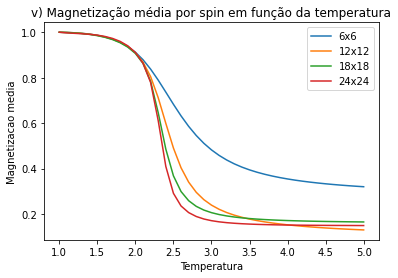

In [20]:
#v) Magnetização média por spin, m/N.
def grafico_temperatura_magnetizacaomediaporspin(L):
    N = L * L
    ge = np.exp(ln_ge[L])
    m_mag = np.array([])
    
    for t in temperaturas:
        z_t, e_t, cv_t = media_termodinamica(ln_ge[L], t, L)
        b = 1 / t
        m_t = 0
        maior = maior_exp(b, N)
        for e_esc in range(len(m_micro[L])):
            if e_esc != 1 and e_esc != len(m_micro[L]) - 2:
                e = energia_reescalada(e_esc, N)
                m_t += m_micro[L][e_esc] * ge[e_esc] * (math.e ** (-b * e - maior))
        m_mag_t = m_t / (z_t * N)

        m_mag = np.append(m_mag, m_mag_t)
    m_mag = m_mag / np.max(m_mag)
    plt.plot(temperaturas, m_mag, label=f"{L}x{L}")
    
for L in [6, 12, 18, 24]:
    grafico_temperatura_magnetizacaomediaporspin(L)


plt.xlabel("Temperatura")
plt.ylabel("Magnetizacao media")
plt.legend()
plt.title("v) Magnetização média por spin em função da temperatura")
plt.show()

O grafico v podemos notar uma queda drastica da magnetização média após a temperatura 2, ficando bem próxima de 0.